In [2]:
import os
import numpy as np

import torch
from torch import nn
from torch import optim

import matplotlib as mpl
from matplotlib import pyplot as plt

In [3]:
def plot_data_matrix(X, ax, show=False):
    """Visualize data matrix of neural responses using a heatmap
  
    Args:
      X (torch.Tensor or np.ndarray): matrix of neural responses to visualize
          with a heatmap
      ax (matplotlib axes): where to plot
      show (boolean): enable plt.show()
  
    """

    cax = ax.imshow(X, cmap=mpl.cm.pink, vmin=np.percentile(X, 1),
                    vmax=np.percentile(X, 99))
    cbar = plt.colorbar(cax, ax=ax, label='normalized neural response')

    ax.set_aspect('auto')
    ax.set_xticks([])
    ax.set_yticks([])
    if show:
        plt.show()


def plot_train_loss(train_loss):
    plt.plot(train_loss)
    plt.xlim([0, None])
    plt.ylim([0, None])
    plt.xlabel('iterations of gradient descent')
    plt.ylabel('mean squared error')
    plt.show()

In [4]:
def load_data(data_name, bin_width=1):
    """Load mouse V1 data from Stringer et al. (2019)
  
    Data from study reported in this preprint:
    https://www.biorxiv.org/content/10.1101/679324v2.abstract
  
    These data comprise time-averaged responses of ~20,000 neurons
    to ~4,000 stimulus gratings of different orientations, recorded
    through Calcium imaging. The responses have been normalized by
    spontaneous levels of activity and then z-scored over stimuli, so
    expect negative numbers. They have also been binned and averaged
    to each degree of orientation.
  
    This function returns the relevant data (neural responses and
    stimulus orientations) in a torch.Tensor of data type torch.float32
    in order to match the default data type for nn.Parameters in
    Google Colab.
  
    This function will actually average responses to stimuli with orientations
    falling within bins specified by the bin_width argument. This helps
    produce individual neural "responses" with smoother and more
    interpretable tuning curves.
  
    Args:
      bin_width (float): size of stimulus bins over which to average neural
        responses
  
    Returns:
      resp (torch.Tensor): n_stimuli x n_neurons matrix of neural responses,
          each row contains the responses of each neuron to a given stimulus.
          As mentioned above, neural "response" is actually an average over
          responses to stimuli with similar angles falling within specified bins.
      stimuli: (torch.Tensor): n_stimuli x 1 column vector with orientation
          of each stimulus, in degrees. This is actually the mean orientation
          of all stimuli in each bin.
  
    """
    with np.load(data_name) as dobj:
        data = dict(**dobj)
    resp = data['resp']
    stimuli = data['stimuli']

    if bin_width > 1:
        # Bin neural responses and stimuli
        bins = np.digitize(stimuli, np.arange(0, 360 + bin_width, bin_width))
        stimuli_binned = np.array([stimuli[bins == i].mean() for i in np.unique(bins)])
        resp_binned = np.array([resp[bins == i, :].mean(0) for i in np.unique(bins)])
    else:
        resp_binned = resp
        stimuli_binned = stimuli

    # Return as torch.Tensor
    resp_tensor = torch.tensor(resp_binned, dtype=torch.float32)
    stimuli_tensor = torch.tensor(stimuli_binned, dtype=torch.float32).unsqueeze(1)  # add singleton dimension to make a column vector

    return resp_tensor, stimuli_tensor


def get_data(n_stim, train_data, train_labels):
    """ Return n_stim randomly drawn stimuli/resp pairs
  
    Args:
      n_stim (scalar): number of stimuli to draw
      resp (torch.Tensor):
      train_data (torch.Tensor): n_train x n_neurons tensor with neural
        responses to train on
      train_labels (torch.Tensor): n_train x 1 tensor with orientations of the
        stimuli corresponding to each row of train_data, in radians
  
    Returns:
      (torch.Tensor, torch.Tensor): n_stim x n_neurons tensor of neural responses and n_stim x 1 of orientations respectively
    """
    n_stimuli = train_labels.shape[0]
    istim = np.random.choice(n_stimuli, n_stim)
    r = train_data[istim]  # neural responses to this stimulus
    ori = train_labels[istim]  # true stimulus orientation

    return r, ori

In [9]:
data = np.arange(0, 10, 0.2)
binned = np.digitize(data, np.arange(0, 10, 2))
data_with_bins = np.column_stack([data, binned])

array([[0. , 1. ],
       [0.2, 1. ],
       [0.4, 1. ],
       [0.6, 1. ],
       [0.8, 1. ],
       [1. , 1. ],
       [1.2, 1. ],
       [1.4, 1. ],
       [1.6, 1. ],
       [1.8, 1. ],
       [2. , 2. ],
       [2.2, 2. ],
       [2.4, 2. ],
       [2.6, 2. ],
       [2.8, 2. ],
       [3. , 2. ],
       [3.2, 2. ],
       [3.4, 2. ],
       [3.6, 2. ],
       [3.8, 2. ],
       [4. , 3. ],
       [4.2, 3. ],
       [4.4, 3. ],
       [4.6, 3. ],
       [4.8, 3. ],
       [5. , 3. ],
       [5.2, 3. ],
       [5.4, 3. ],
       [5.6, 3. ],
       [5.8, 3. ],
       [6. , 4. ],
       [6.2, 4. ],
       [6.4, 4. ],
       [6.6, 4. ],
       [6.8, 4. ],
       [7. , 4. ],
       [7.2, 4. ],
       [7.4, 4. ],
       [7.6, 4. ],
       [7.8, 4. ],
       [8. , 5. ],
       [8.2, 5. ],
       [8.4, 5. ],
       [8.6, 5. ],
       [8.8, 5. ],
       [9. , 5. ],
       [9.2, 5. ],
       [9.4, 5. ],
       [9.6, 5. ],
       [9.8, 5. ]])

In [5]:
import hashlib
import requests

fname = "W3D4_stringer_oribinned1.npz"
url = "https://osf.io/683xc/download"
expected_md5 = "436599dfd8ebe6019f066c38aed20580"

if not os.path.isfile(fname):
    try:
        r = requests.get(url)
    except requests.ConnectionError:
        print("!!! Failed to download data !!!")
    else:
        if r.status_code != requests.codes.ok:
            print("!!! Failed to download data !!!")
        elif hashlib.md5(r.content).hexdigest() != expected_md5:
            print("!!! Data download appears corrupted !!!")
        else:
            with open(fname, "wb") as fid:
                fid.write(r.content)

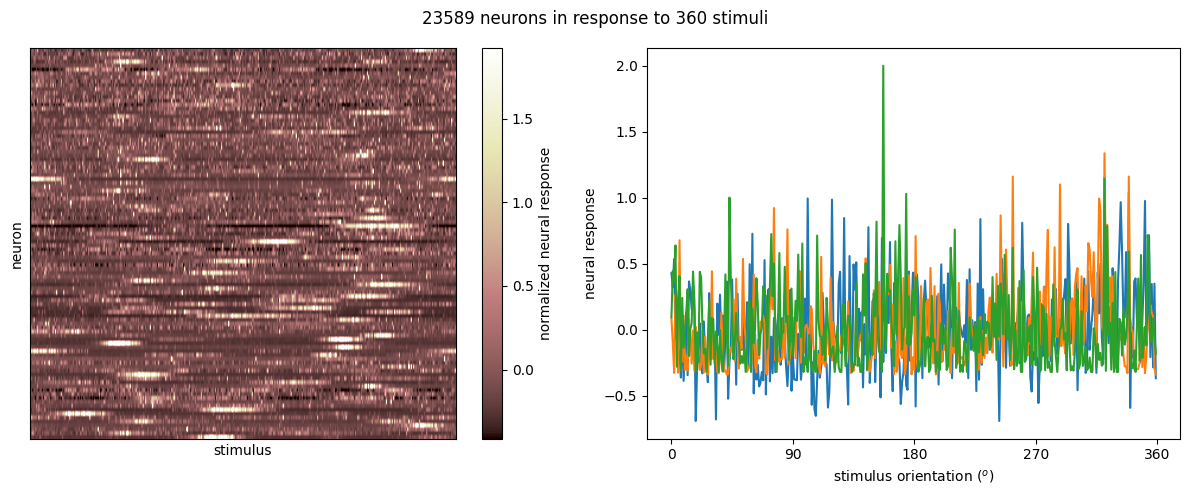

In [6]:
resp_all, stimuli_all = load_data(fname)  # argument to this function specifies bin width
n_stimuli, n_neurons = resp_all.shape

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(2 * 6, 5))

# Visualize data matrix
# TODO: are the x / y labels correct here?
plot_data_matrix(resp_all[:, :100].T, ax1)  # plot responses of first 100 neurons
ax1.set_xlabel('stimulus')
ax1.set_ylabel('neuron')

# Plot tuning curves of three random neurons
ineurons = np.random.choice(n_neurons, 3, replace=False)  # pick three random neurons
ax2.plot(stimuli_all, resp_all[:, ineurons])
ax2.set_xlabel('stimulus orientation ($^o$)')
ax2.set_ylabel('neural response')
ax2.set_xticks(np.linspace(0, 360, 5))

fig.suptitle(f'{n_neurons} neurons in response to {n_stimuli} stimuli')
fig.tight_layout()
plt.show()

In [33]:
print(resp_all.shape)
print(stimuli_all.shape)

torch.Size([360, 23589])
torch.Size([360, 1])


In [22]:
np.random.seed(4)
torch.manual_seed(4)

# Split data into training set and testing set
n_train = int(0.6 * n_stimuli)  # use 60% of all data for training set
ishuffle = torch.randperm(n_stimuli)
itrain = ishuffle[:n_train]
itest = ishuffle[n_train:]
stimuli_train = stimuli_all[itrain]
resp_train = resp_all[itrain]
stimuli_test = stimuli_all[itest]
resp_test = resp_all[itest]

In [23]:
class DeepNet(nn.Module):
    def __init__(self, n_inputs, n_hidden):
        super.__init__()
        self.in_layer = nn.Linear(n_inputs, n_hidden)
        self.out_layer = nn.Linear(n_hidden, 1)
    
    def forward(self, r):
        h = self.in_layer(r)
        y = self.out_layer(h)
        return y

In [24]:
class DeepNetReLU(nn.Module):
    def __init__(self, n_inputs, n_hidden):
        super().__init__()
        self.in_layer = nn.Linear(n_inputs, n_hidden)
        self.out_layer = nn.Linear(n_hidden, 1)

    def forward(self, r):
        h = torch.relu(self.in_layer(r))
        y = self.out_layer(h)
        return y

np.random.seed(1)
torch.manual_seed(1)

# Initialize a deep network with M=200 hidden units
net = DeepNetReLU(n_neurons, 200)

# Get neural responses (r) to and orientation (ori) to one stimulus in dataset
r, ori = get_data(1, resp_train, stimuli_train)  # using helper function get_data

# Decode orientation from these neural responses using initialized network
out = net(r)  # compute output from network, equivalent to net.forward(r)

print(f'decoded orientation: {out.item():.2f} degrees')
print(f'true orientation: {ori.item():.2f} degrees')

decoded orientation: 0.17 degrees
true orientation: 139.00 degrees


iteration 10/50 | loss: 12219.759
iteration 20/50 | loss: 1672.731
iteration 30/50 | loss: 548.097
iteration 40/50 | loss: 235.619
iteration 50/50 | loss: 144.001


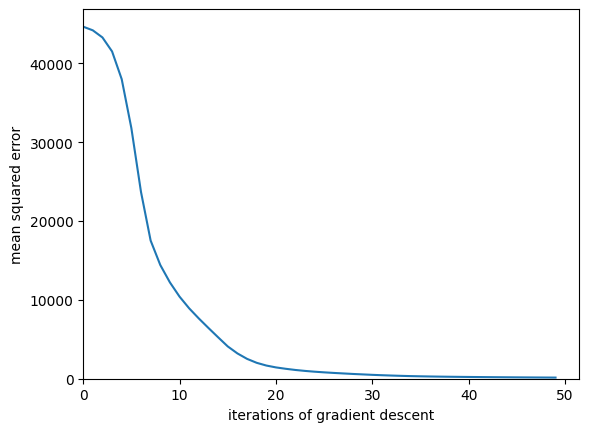

In [25]:
def train(net, loss_fn, train_data, train_labels,
          n_epochs=50, learning_rate=1e-4):
    """Run gradient descent to optimize parameters of a given network
  
    Args:
      net (nn.Module): PyTorch network whose parameters to optimize
      loss_fn: built-in PyTorch loss function to minimize
      train_data (torch.Tensor): n_train x n_neurons tensor with neural
        responses to train on
      train_labels (torch.Tensor): n_train x 1 tensor with orientations of the
        stimuli corresponding to each row of train_data
      n_epochs (int, optional): number of epochs of gradient descent to run
      learning_rate (float, optional): learning rate to use for gradient descent
  
    Returns:
      (list): training loss over iterations
  
    """

    # Initialize PyTorch SGD optimizer
    optimizer = optim.SGD(net.parameters(), lr=learning_rate)

    # Placeholder to save the loss at each iteration
    train_loss = []

    # Loop over epochs
    for i in range(n_epochs):

        # compute network output from inputs in train_data
        out = net(train_data)  # compute network output from inputs in train_data

        # evaluate loss function
        loss = loss_fn(out, train_labels)

        # Clear previous gradients
        optimizer.zero_grad()

        # Compute gradients
        loss.backward()

        # Update weights
        optimizer.step()

        # Store current value of loss
        train_loss.append(loss.item())  # .item() needed to transform the tensor output of loss_fn to a scalar

        # Track progress
        if (i + 1) % (n_epochs // 5) == 0:
            print(f'iteration {i + 1}/{n_epochs} | loss: {loss.item():.3f}')

    return train_loss


# Set random seeds for reproducibility
np.random.seed(1)
torch.manual_seed(1)

# Initialize network with 10 hidden units
net = DeepNetReLU(n_neurons, 10)

# Initialize built-in PyTorch MSE loss function
loss_fn = nn.MSELoss()

# Run gradient descent on data
train_loss = train(net, loss_fn, resp_train, stimuli_train)

# Plot the training loss over iterations of GD
plot_train_loss(train_loss)

In [28]:
def show_stimulus(img, ax=None, show=False):
    """Visualize a stimulus"""
    if ax is None:
        ax = plt.gca()
    ax.imshow(img+0.5, cmap=mpl.cm.binary)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.spines['left'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    if show:
        plt.show()


def plot_weights(weights, channels=[0]):
    """ plot convolutional channel weights
    Args:
        weights: weights of convolutional filters (conv_channels x K x K)
        channels: which conv channels to plot
    """
    wmax = torch.abs(weights).max()
    fig, axs = plt.subplots(1, len(channels), figsize=(12, 2.5))
    for i, channel in enumerate(channels):
        im = axs[i].imshow(weights[channel, 0], vmin=-wmax, vmax=wmax, cmap='bwr')
        axs[i].set_title(f'channel {channel}')

        cb_ax = fig.add_axes([1, 0.1, 0.05, 0.8])
        plt.colorbar(im, ax=cb_ax)
        cb_ax.axis('off')
    plt.show()


def plot_example_activations(stimuli, act, channels=[0]):
    """ plot activations act and corresponding stimulus
    Args:
      stimuli: stimulus input to convolutional layer (n x h x w) or (h x w)
      act: activations of convolutional layer (n_bins x conv_channels x n_bins)
      channels: which conv channels to plot
    """
    if stimuli.ndim>2:
        n_stimuli = stimuli.shape[0]
    else:
        stimuli = stimuli.unsqueeze(0)
        n_stimuli = 1

    fig, axs = plt.subplots(n_stimuli, 1 + len(channels), figsize=(12, 12))

    # plot stimulus
    for i in range(n_stimuli):
        show_stimulus(stimuli[i].squeeze(), ax=axs[i, 0])
        axs[i, 0].set_title('stimulus')

        # plot example activations
        for k, (channel, ax) in enumerate(zip(channels, axs[i][1:])):
            im = ax.imshow(act[i, channel], vmin=-3, vmax=3, cmap='bwr')
            ax.set_xlabel('x-pos')
            ax.set_ylabel('y-pos')
            ax.set_title(f'channel {channel}')

        cb_ax = fig.add_axes([1.05, 0.8, 0.01, 0.1])
        plt.colorbar(im, cax=cb_ax)
        cb_ax.set_title('activation\n strength')
    plt.show()

In [29]:
def load_data_split(data_name):
    """Load mouse V1 data from Stringer et al. (2019)
  
    Data from study reported in this preprint:
    https://www.biorxiv.org/content/10.1101/679324v2.abstract
  
    These data comprise time-averaged responses of ~20,000 neurons
    to ~4,000 stimulus gratings of different orientations, recorded
    through Calcium imaginge. The responses have been normalized by
    spontaneous levels of activity and then z-scored over stimuli, so
    expect negative numbers. The repsonses were split into train and
    test and then each set were averaged in bins of 6 degrees.
  
    This function returns the relevant data (neural responses and
    stimulus orientations) in a torch.Tensor of data type torch.float32
    in order to match the default data type for nn.Parameters in
    Google Colab.
  
    It will hold out some of the trials when averaging to allow us to have test
    tuning curves.
  
    Args:
      data_name (str): filename to load
  
    Returns:
      resp_train (torch.Tensor): n_stimuli x n_neurons matrix of neural responses,
          each row contains the responses of each neuron to a given stimulus.
          As mentioned above, neural "response" is actually an average over
          responses to stimuli with similar angles falling within specified bins.
      resp_test (torch.Tensor): n_stimuli x n_neurons matrix of neural responses,
          each row contains the responses of each neuron to a given stimulus.
          As mentioned above, neural "response" is actually an average over
          responses to stimuli with similar angles falling within specified bins
      stimuli: (torch.Tensor): n_stimuli x 1 column vector with orientation
          of each stimulus, in degrees. This is actually the mean orientation
          of all stimuli in each bin.
  
    """
    with np.load(data_name) as dobj:
        data = dict(**dobj)
    resp_train = data['resp_train']
    resp_test = data['resp_test']
    stimuli = data['stimuli']

    # Return as torch.Tensor
    resp_train_tensor = torch.tensor(resp_train, dtype=torch.float32)
    resp_test_tensor = torch.tensor(resp_test, dtype=torch.float32)
    stimuli_tensor = torch.tensor(stimuli, dtype=torch.float32)

    return resp_train_tensor, resp_test_tensor, stimuli_tensor


def filters(out_channels=6, K=7):
    """ make example filters, some center-surround and gabors
    Returns:
        filters: out_channels x K x K
    """
    grid = np.linspace(-K/2, K/2, K).astype(np.float32)
    xx,yy = np.meshgrid(grid, grid, indexing='ij')

    # create center-surround filters
    sigma = 1.1
    gaussian = np.exp(-(xx**2 + yy**2)**0.5/(2*sigma**2))
    wide_gaussian = np.exp(-(xx**2 + yy**2)**0.5/(2*(sigma*2)**2))
    center_surround = gaussian - 0.5 * wide_gaussian

    # create gabor filters
    thetas = np.linspace(0, 180, out_channels-2+1)[:-1] * np.pi/180
    gabors = np.zeros((len(thetas), K, K), np.float32)
    lam = 10
    phi = np.pi/2
    gaussian = np.exp(-(xx**2 + yy**2)**0.5/(2*(sigma*0.4)**2))
    for i,theta in enumerate(thetas):
        x = xx*np.cos(theta) + yy*np.sin(theta)
        gabors[i] = gaussian * np.cos(2*np.pi*x/lam + phi)

    filters = np.concatenate((center_surround[np.newaxis,:,:],
                              -1*center_surround[np.newaxis,:,:],
                              gabors),
                             axis=0)
    filters /= np.abs(filters).max(axis=(1,2))[:,np.newaxis,np.newaxis]
    filters -= filters.mean(axis=(1,2))[:,np.newaxis,np.newaxis]
    # convert to torch
    filters = torch.from_numpy(filters)
    # add channel axis
    filters = filters.unsqueeze(1)

    return filters


def grating(angle, sf=1 / 28, res=0.1, patch=False):
    """Generate oriented grating stimulus
  
    Args:
      angle (float): orientation of grating (angle from vertical), in degrees
      sf (float): controls spatial frequency of the grating
      res (float): resolution of image. Smaller values will make the image
        smaller in terms of pixels. res=1.0 corresponds to 640 x 480 pixels.
      patch (boolean): set to True to make the grating a localized
        patch on the left side of the image. If False, then the
        grating occupies the full image.
  
    Returns:
      torch.Tensor: (res * 480) x (res * 640) pixel oriented grating image
  
    """

    angle = np.deg2rad(angle)  # transform to radians

    wpix, hpix = 640, 480  # width and height of image in pixels for res=1.0

    xx, yy = np.meshgrid(sf * np.arange(0, wpix * res) / res, sf * np.arange(0, hpix * res) / res)

    if patch:
        gratings = np.cos(xx * np.cos(angle + .1) + yy * np.sin(angle + .1))  # phase shift to make it better fit within patch
        gratings[gratings < 0] = 0
        gratings[gratings > 0] = 1
        xcent = gratings.shape[1] * .75
        ycent = gratings.shape[0] / 2
        xxc, yyc = np.meshgrid(np.arange(0, gratings.shape[1]), np.arange(0, gratings.shape[0]))
        icirc = ((xxc - xcent) ** 2 + (yyc - ycent) ** 2) ** 0.5 < wpix / 3 / 2 * res
        gratings[~icirc] = 0.5

    else:
        gratings = np.cos(xx * np.cos(angle) + yy * np.sin(angle))
        gratings[gratings < 0] = 0
        gratings[gratings > 0] = 1

    gratings -= 0.5

    # Return torch tensor
    return torch.tensor(gratings, dtype=torch.float32)

In [31]:

import hashlib
import requests

fname = "W3D4_stringer_oribinned6_split.npz"
url = "https://osf.io/p3aeb/download"
expected_md5 = "b3f7245c6221234a676b71a1f43c3bb5"

if not os.path.isfile(fname):
    try:
        r = requests.get(url)
    except requests.ConnectionError:
        print("!!! Failed to download data !!!")
    else:
        if r.status_code != requests.codes.ok:
            print("!!! Failed to download data !!!")
        elif hashlib.md5(r.content).hexdigest() != expected_md5:
            print("!!! Data download appears corrupted !!!")
        else:
            with open(fname, "wb") as fid:
                fid.write(r.content)

In [32]:
class ConvolutionalLayer(nn.Module):
    """Deep network with one convolutional layer
       Attributes: conv (nn.Conv2d): convolutional layer
    """
    def __init__(self, c_in=1, c_out=6, K=7, filters=None):
        """Initialize layer
    
        Args:
            c_in: number of input stimulus channels
            c_out: number of output convolutional channels
            K: size of each convolutional filter
            filters: (optional) initialize the convolutional weights
    
        """
        super().__init__()
        self.conv = nn.Conv2d(c_in, c_out, kernel_size=K,
                              padding=K//2, stride=1)
        if filters is not None:
            self.conv.weight = nn.Parameter(filters)
            self.conv.bias = nn.Parameter(torch.zeros((c_out,), dtype=torch.float32))

    def forward(self, s):
        """Run stimulus through convolutional layer
    
        Args:
            s (torch.Tensor): n_stimuli x c_in x h x w tensor with stimuli
    
        Returns:
            (torch.Tensor): n_stimuli x c_out x h x w tensor with convolutional layer unit activations.
    
        """
        a = self.conv(s)  # output of convolutional layer

        return a

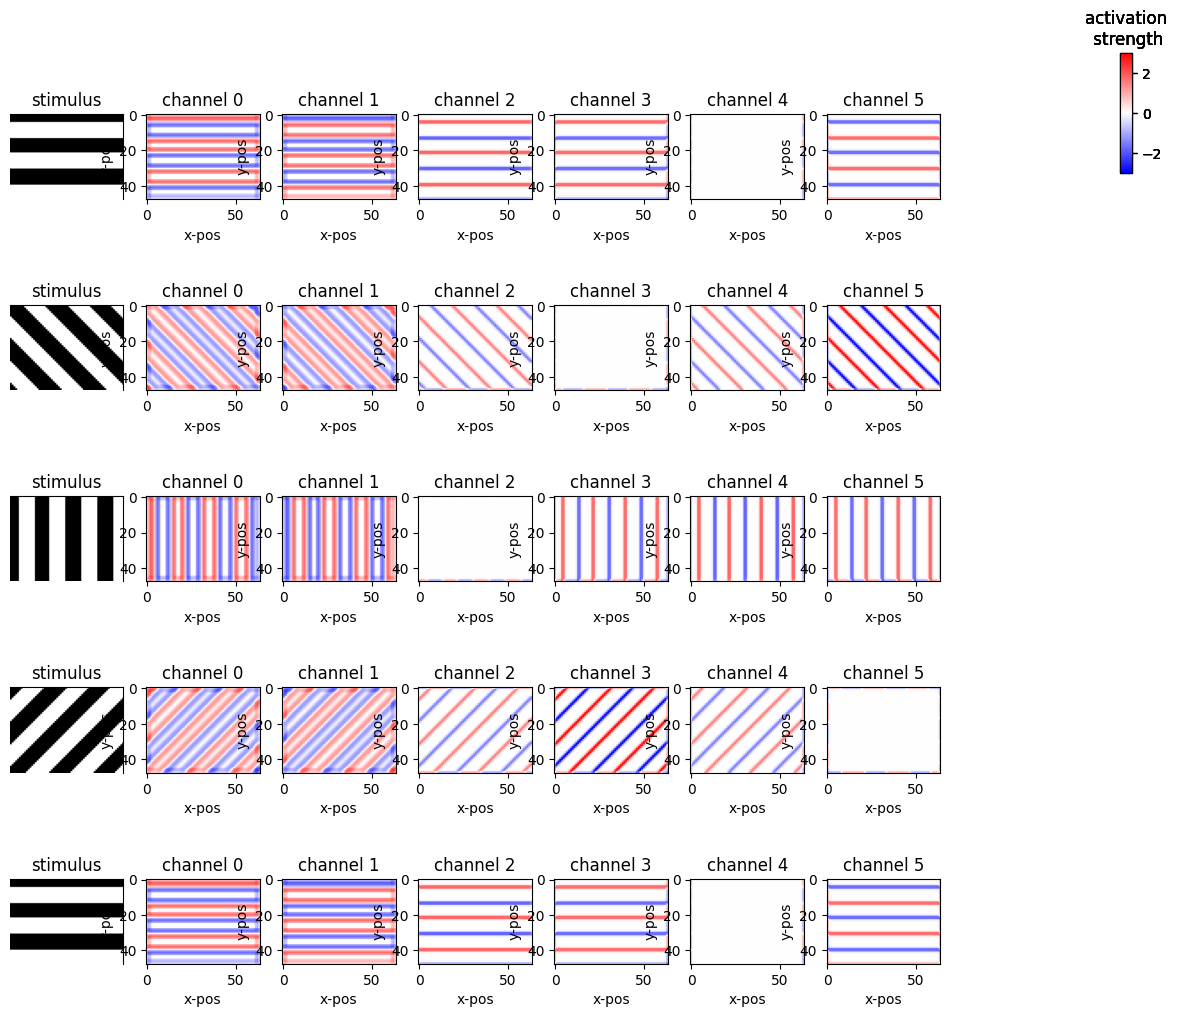

In [34]:
# Stimulus parameters
in_channels = 1  # how many input channels in our images
h = 48  # height of images
w = 64  # width of images

# Convolution layer parameters
K = 7  # filter size
out_channels = 6  # how many convolutional channels to have in our layer
example_filters = filters(out_channels, K)  # create filters to use

convout = np.zeros(0)  # assign convolutional activations to convout

# Initialize conv layer and add weights from function filters
# you need to specify :
# * the number of input channels c_in
# * the number of output channels c_out
# * the filter size K
convLayer = ConvolutionalLayer(c_in=in_channels, c_out=out_channels, K=K, filters=example_filters)

# Create stimuli (H_in, W_in)
orientations = [-90, -45, 0, 45, 90]
stimuli = torch.zeros((len(orientations), in_channels, h, w), dtype=torch.float32)
for i,ori in enumerate(orientations):
    stimuli[i, 0] = grating(ori)

convout = convLayer(stimuli)
convout = convout.detach()  # detach gradients

plot_example_activations(stimuli, convout, channels=np.arange(0, out_channels))

In [43]:
print("Activation Shape: ", convout.shape)
print("Stimulus shape: ", h, w)
print("Number of filters / output channels: ", out_channels)
print("Numbe of stimulus: ", len(stimuli))


Activation Shape:  torch.Size([5, 6, 48, 64])
Stimulus shape:  48 64
Number of filters / output channels:  6
Numbe of stimulus:  5


NameError: name 'width' is not defined